In [7]:
from polygon import RESTClient
import pandas as pd
import numpy as np
import datetime as dt
import requests
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

client = RESTClient("2zH7AFDp4wW1Uqov4zGvbpA2aUNHbk__adRrOG")  # POLYGON_API_KEY environment variable is used

In [8]:
def get_stock(ticker, multiplier, timespan, start_date, end_date):
    
    # Construct the URL
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/{multiplier}/{timespan}/{start_date}/{end_date}"
    params = {
        "apiKey": API_KEY,
        "adjusted": "false" ,
        "limit":50000
    }
    
    # Make the API request
    response = requests.get(url, params=params)
    
    # Check response status
    if response.status_code == 200:
        print("success")
    else:
        print(f"Error: {response.status_code}, {response.text}")

    df = pd.DataFrame(response.json()['results'])
    df['t'] = pd.to_datetime(df['t'], unit='ms')  # Convert timestamp to datetime
    df.set_index('t', inplace=True)  # Set timestamp as index
    df.rename(columns={'o': 'Open', 'h': 'High', 'l': 'Low', 'c': 'Close', 'v': 'Volume','n':'n_trades'}, inplace=True)

    return df

success


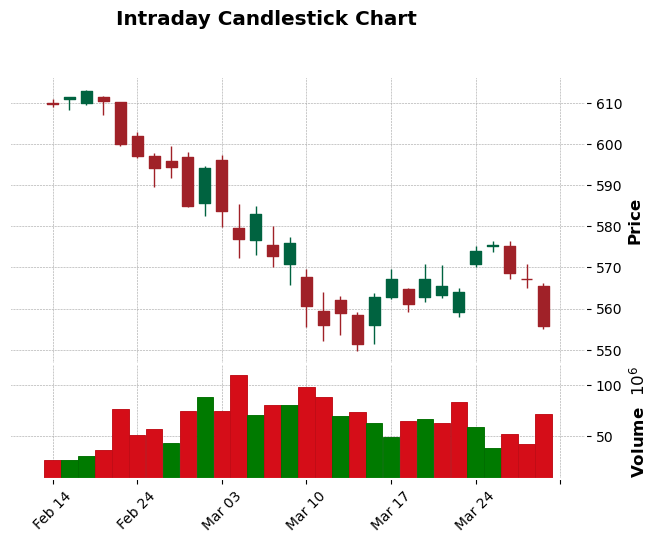

In [9]:
import datetime as dt
import pytz
import time

def convert_to_us_time(df, timezone='US/Eastern'):
    """
    Convert the timestamp to US Eastern Time.
    """
    eastern = pytz.timezone(timezone)
    df.index = df.index.tz_localize(pytz.utc).tz_convert(eastern)
    return df

today_string = dt.datetime.now().date().strftime('%Y-%m-%d')

API_KEY = "2zH7AFDp4wW1Uqov4zGvbpA2aUNHbk__adRrOG"
multiplier = 1
timespan = "day"
start_date = "2024-01-01"
end_date = today_string

stocks = {}
for ticker in ['SPY']:
    stock = convert_to_us_time(get_stock(ticker, multiplier, timespan,start_date,end_date))
    stocks[ticker] = stock

import mplfinance as mpf

# Select the required columns for the candlestick plot
data = stocks['SPY'][['Open', 'High', 'Low', 'Close', 'Volume']].tail(30)

# Plot the candlestick chart
mpf.plot(data, type='candle', volume=True, title= 'Intraday Candlestick Chart', style='charles')

## Fair Volatility Estimate
<br> Third EyE market

In [10]:
VIX = pd.read_csv('data/VIX_History.csv')
VIX['DATE'] = pd.to_datetime(VIX['DATE'])
VIX.set_index('DATE', inplace=True)

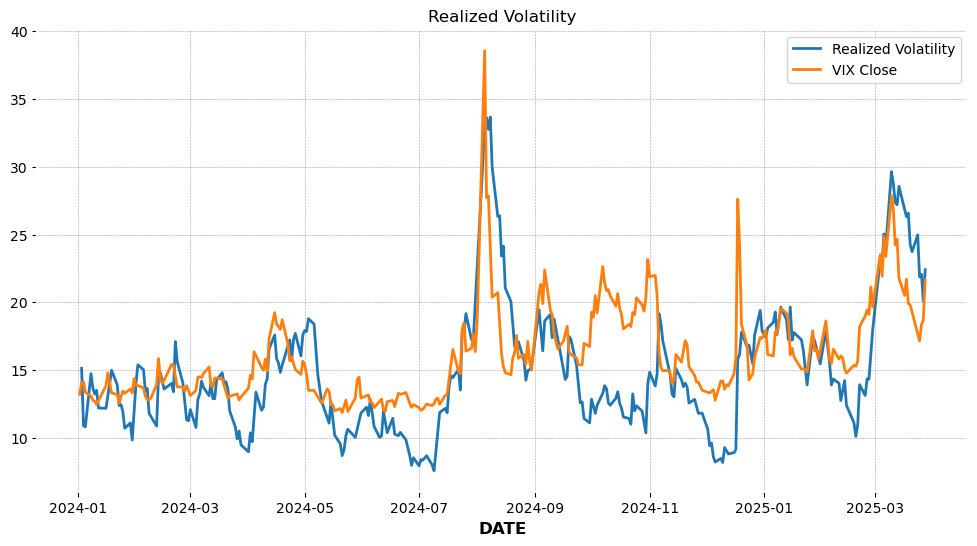

In [29]:
spy = stocks['SPY'].copy()
spy.reset_index(inplace=True)
spy.rename(columns={'t': 'DATE'}, inplace=True)
spy['DATE'] = pd.to_datetime(spy['DATE']).dt.date
spy.set_index('DATE', inplace=True)
spy['close_to_high'] = np.log(spy['High'] / spy['Close'].shift(1)) 
spy['close_to_low'] = np.log(spy['Low'] / spy['Close'].shift(1))

adj_factor1 = 1
spy['range high - low'] = abs(spy['close_to_high']) - abs(spy['close_to_low'])
spy['realized vol'] = np.sqrt(252) * abs(spy.apply(lambda x: x['close_to_high'] if x['range high - low'] >= 0 else x['close_to_low'], axis=1))
spy['ewm realized vol'] = spy['realized vol'].ewm(span = 11).mean() * adj_factor1 * 100
spy['VIX Close'] = VIX['CLOSE']
spy['ewm realized vol'].plot(figsize=(12, 6), title='Realized Volatility', label = 'Realized Volatility')
spy['VIX Close'].plot(label = 'VIX Close')
plt.legend()

In [25]:
import pandas as pd
import yfinance as yf
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator, StochRSIIndicator
from scipy.stats import linregress

def calculate_indicators(ticker, start_date, end_date):
    # Fetch historical data
    data = spy.copy()
    if data.empty:
        print(f"No data found for {ticker} in the specified date range.")
        return None

    # Calculate RSI
    data['RSI'] = RSIIndicator(data['Close'], window=22).rsi()

    # Calculate Stochastic RSI
    stoch_rsi = StochRSIIndicator(data['Close'], window=14, smooth1=3, smooth2=3)
    data['Stoch_RSI'] = stoch_rsi.stochrsi()

    # Calculate Linear Regression Slope (LRS)
    window = 11  # Define the rolling window size
    slopes = []
    for i in range(len(data)):
        if i < window - 1:
            slopes.append(None)  # Not enough data for the window
        else:
            y = data['Close'].iloc[i - window + 1:i + 1]
            x = range(len(y))
            slope, _, _, _, _ = linregress(x, y)
            slopes.append(slope)
    data['LRS'] = slopes

    return data[['Close', 'ewm realized vol','VIX Close','RSI', 'Stoch_RSI', 'LRS']]

# Example usage
ticker = "AAPL"  # Replace with your desired ticker
start_date = "2025-03-01"  # Replace with your desired start date
end_date = "2025-03-29"    # Replace with your desired end date

indicators_data = calculate_indicators(ticker, start_date, end_date)
if indicators_data is not None:
    print(indicators_data)

             Close  ewm realized vol  VIX Close        RSI  Stoch_RSI  \
DATE                                                                    
2024-01-02  472.65               NaN      13.20        NaN        NaN   
2024-01-03  468.79         15.118372      14.04        NaN        NaN   
2024-01-04  467.28         10.870855      14.13        NaN        NaN   
2024-01-05  467.92         10.802894      13.35        NaN        NaN   
2024-01-08  474.60         14.730446      13.08        NaN        NaN   
...            ...               ...        ...        ...        ...   
2025-03-24  574.08         24.967976      17.48  46.408502   1.000000   
2025-03-25  575.46         21.878296      17.15  47.060085   1.000000   
2025-03-26  568.59         22.061738      18.33  44.253960   0.792097   
2025-03-27  567.08         20.088667      18.69  43.654573   0.748181   
2025-03-28  555.66         22.404092      21.65  39.423916   0.448187   

                 LRS  
DATE                  
2024

In [58]:
scaler = 1 + (0.75 * indicators_data['ewm realized vol'] / indicators_data['VIX Close'].mean())

indicators_data['Fear_RSI'] = (100 - indicators_data['RSI']) / 100 * scaler
indicators_data['Fear_Stoch_RSI'] = (100 - indicators_data['Stoch_RSI']) / 100 * scaler

indicators_data['Fear_LRS'] = (indicators_data['LRS'].rolling(11).mean() - indicators_data['LRS'])* scaler
indicators_data['Fear_Realized Vol'] = indicators_data['ewm realized vol'].ewm(span=11).mean() * 0.75

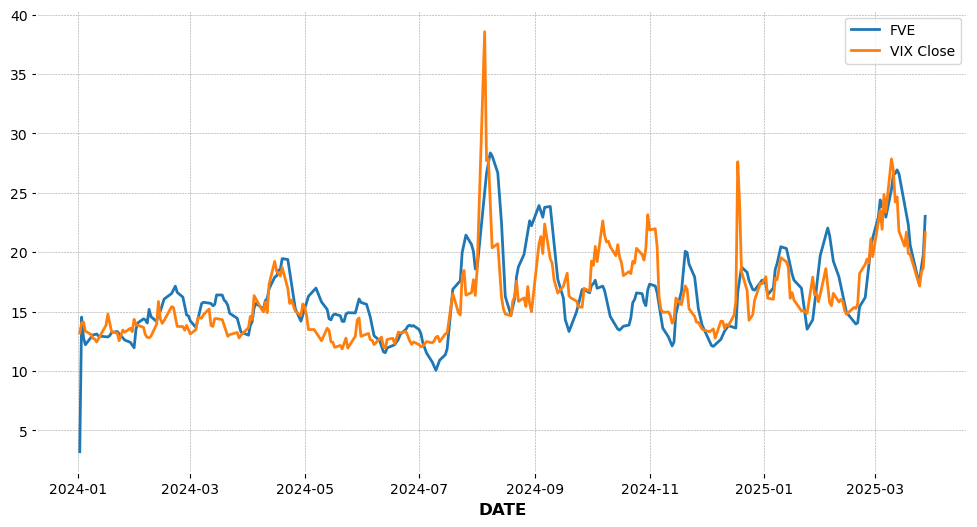

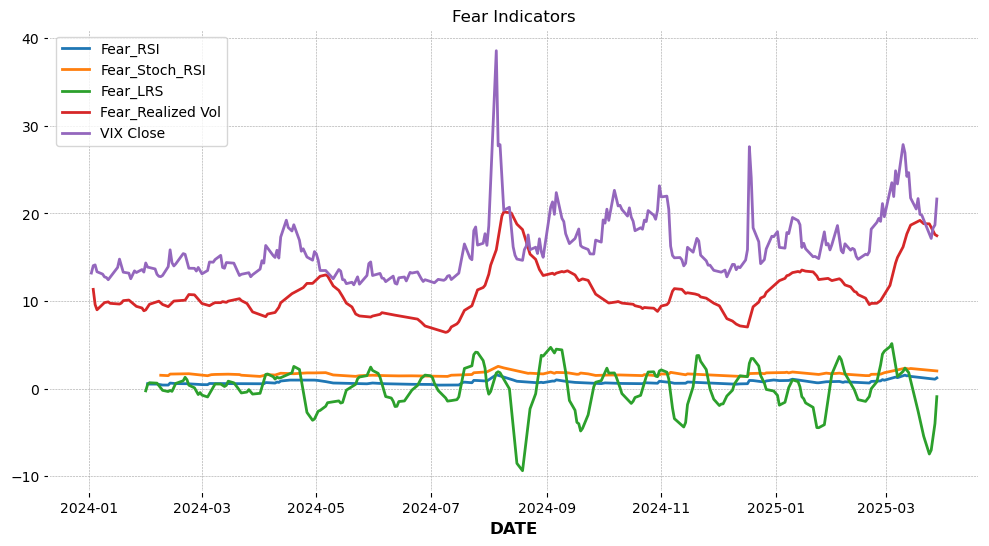

In [69]:
(3.2 + indicators_data[['Fear_RSI', 'Fear_Stoch_RSI', 'Fear_LRS','Fear_Realized Vol']].sum(axis = 1)).plot(figsize=(12, 6), label ='FVE')
indicators_data['VIX Close'].plot(label = 'VIX Close')
plt.legend()
indicators_data[['Fear_RSI', 'Fear_Stoch_RSI', 'Fear_LRS','Fear_Realized Vol','VIX Close']].plot(figsize=(12, 6), title='Fear Indicators', label = 'FVE')

